<a href="https://colab.research.google.com/github/ravi-gopalan/dog_breed_classifier_udacity/blob/master/dog_breed_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Files

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import timeit
import os
import matplotlib.pyplot as plt
from pathlib import Path


from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import cv2                
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from keras.preprocessing import image                  
from tqdm import tqdm

from PIL import ImageFile

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint 


Using TensorFlow backend.


In [2]:
# Clone the entire repo.
git_clone_start_time = timeit.default_timer()
!git clone -l -s git://github.com/ravi-gopalan/dog_breed_classifier_udacity.git cloned-repository
%cd cloned-repository
!ls
git_clone_stop_time = timeit.default_timer()
git_clone_time  = git_clone_stop_time - git_clone_start_time
print('git_clone_time: {}'.format(git_clone_time))

Cloning into 'cloned-repository'...
remote: Enumerating objects: 27753, done.
remote: Counting objects: 100% (27753/27753), done.
remote: Compressing objects: 100% (25998/25998), done.
remote: Total 27753 (delta 18), reused 27733 (delta 9), pack-reused 0
Receiving objects: 100% (27753/27753), 1.22 GiB | 53.45 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (21589/21589), done.
/content/cloned-repository
dog_breed_classifier.ipynb	haarcascades  lfw
extract_bottleneck_features.py	images	      README.md
git_clone_time: 40.82559840199974


In [3]:
gdrive_mount_start_time = timeit.default_timer()

from google.colab import drive
drive.mount('/gdrive')
gdrive_mount_stop_time = timeit.default_timer()
gdrive_mount_time = gdrive_mount_stop_time - gdrive_mount_start_time
print('gdrive_mount_time: {}'.format(gdrive_mount_time))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
gdrive_mount_time: 27.733152840999992


In [4]:
pwd

'/content/cloned-repository'

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

# Import Files

In [5]:
os.getcwd()

'/content/cloned-repository'

In [0]:

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets



In [0]:
basedir = os.getcwd()

train_dir = os.path.join(basedir,'images/train')
valid_dir = os.path.join(basedir,'images/valid')
test_dir = os.path.join(basedir,'images/test')



In [0]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_dir)
valid_files, valid_targets = load_dataset(valid_dir)
test_files, test_targets = load_dataset(test_dir)



In [0]:
bottleneck_features_dir = '/gdrive/My Drive/Colab_stuff/dog_classifier_models'

In [10]:
# load list of dog names
dog_names = [item[17:-1] for item in sorted(glob("images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [11]:

random.seed(42)

human_dir = os.path.join(basedir,'lfw/*/*')
# load filenames in shuffled human dataset
human_files = np.array(glob(human_dir))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


# Step 1: Detect Humans based on OpenCV Haar cascase classifiers

Step 1: Detect Humans
We use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on github. We have downloaded one of these detectors and stored it in the haarcascades directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


array([[[202, 122,  21],
        [198, 118,  17],
        [190, 111,  14],
        ...,
        [ 58,  56,   8],
        [ 47,  54,  11],
        [ 40,  49,   9]],

       [[197, 119,  19],
        [193, 114,  17],
        [186, 109,  13],
        ...,
        [ 60,  59,   9],
        [ 48,  52,  10],
        [ 42,  50,   9]],

       [[182, 108,  14],
        [180, 106,  12],
        [175, 100,   8],
        ...,
        [ 61,  56,   7],
        [ 51,  52,   8],
        [ 45,  52,   9]],

       ...,

       [[155, 167, 147],
        [160, 172, 152],
        [171, 183, 163],
        ...,
        [221, 232, 212],
        [228, 239, 219],
        [227, 238, 218]],

       [[165, 177, 157],
        [174, 186, 166],
        [187, 199, 179],
        ...,
        [216, 227, 207],
        [222, 233, 213],
        [225, 236, 216]],

       [[177, 189, 169],
        [185, 197, 177],
        [194, 206, 186],
        ...,
        [214, 225, 205],
        [218, 229, 209],
        [221, 232, 212]]

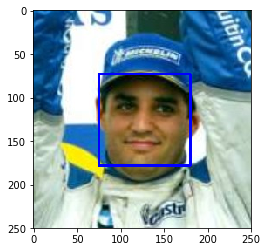

In [12]:
                            

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale. The detectMultiScale function executes the classifier stored in face_cascade and takes the grayscale image as a parameter.

In the above code, faces is a numpy array of detected faces, where each row corresponds to a detected face. Each detected face is a 1D array with four entries that specifies the bounding box of the detected face. The first two entries in the array (extracted in the above code as x and y) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as w and h) specify the width and height of the box.

Write a Human Face Detector
We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, aptly named face_detector, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

IMPLEMENTATION) Assess the Human Face Detector
Question 1: Use the code cell below to test the performance of the face_detector function.

What percentage of the first 100 images in human_files have a detected human face?
What percentage of the first 100 images in dog_files have a detected human face?
Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face. You will see that our algorithm falls short of this goal, but still gives acceptable performance. We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays human_files_short and dog_files_short.

Answer:

Of the 100 human faces, all are detected as a human face
11 of the 100 dog faces are also detected as human faces
Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by Paul Viola and Michael Jones in their paper, "Rapid Object Detection using a Boosted Cascade of Simple Features" in 2001.
It is a machine learning based approach where a cascade function is trained from a lot of positive and negative images.
It is then used to detect objects in other images.
The algorithm uses the Haar frontal face to detect humans. So the expectation is that an image with the frontal features clearly defined is required

In [14]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
num_human_faces_human_files = 0
num_human_faces_dog_files = 0
for i in range(100):
    num_human_faces_human_files += face_detector(human_files_short[i])
    num_human_faces_dog_files += face_detector(dog_files_short[i])    
    
## on the images in human_files_short and dog_files_short.
print('% of human faces detected in human files {:2.2%}\n % of human faces detected in dog files {:2.2%}'\
      .format(num_human_faces_human_files/100, num_human_faces_dog_files/100))

% of human faces detected in human files 99.00%
 % of human faces detected in dog files 12.00%


**Question 2**: This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

**Answer**:

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :). Please use the code cell below to design and test your own face detection algorithm. If you decide to pursue this optional task, report performance on each of the datasets.

# Step 2: Detect Dogs

**Step 2: Detect Dogs**
In this section, we use a pre-trained ResNet-50 model to detect dogs in images. Our first line of code downloads the ResNet-50 model, along with weights that have been trained on ImageNet, a very large, very popular dataset used for image classification and other vision tasks. ImageNet contains over 10 million URLs, each linking to an image containing an object from one of 1000 categories. Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:


# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')








102858752/102853048 [==============================] - 10s 0us/step


**Pre-process the Data**

---


When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape


> (`nb_samples,rows,columns,channels`)


 
where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is  224×224  pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

(1,224,224,3).
 
The paths_to_tensor function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

(nb_samples,224,224,3).
 
Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [0]:


def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Making Predictions with ResNet-50
Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing. First, the RGB image is converted to BGR by reordering the channels. All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as  [103.939,116.779,123.68]  and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image. This is implemented in the imported function preprocess_input. If you're curious, you can check the code for preprocess_input here.

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions. This is accomplished with the predict method, which returns an array whose  𝑖 -th entry is the model's predicted probability that the image belongs to the  𝑖 -th ImageNet category. This is implemented in the ResNet50_predict_labels function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this dictionary.

In [0]:


def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

Write a Dog Detector
While looking at the dictionary, you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the dog_detector function below, which returns True if a dog is detected in an image (and False if not).

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

(IMPLEMENTATION) Assess the Dog Detector
Question 3: Use the code cell below to test the performance of your dog_detector function.

What percentage of the images in human_files_short have a detected dog?
What percentage of the images in dog_files_short have a detected dog?
Answer: 0% of the images in human_files_short have a detected dog 100% of the images in dog_files_short have a detected dog

In [19]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detected = 0
for im in human_files_short:
    dog_detected += dog_detector(im)
    
print('% of images in human_files with a dog detected: {:2.2%}'.format(dog_detected/len(human_files_short)))

dog_detected = 0
for im in dog_files_short:
    dog_detected += dog_detector(im)
    
print('% of images in dog_files with a dog detected: {:2.2%}'.format(dog_detected/len(dog_files_short)))

% of images in human_files with a dog detected: 2.00%
% of images in dog_files with a dog detected: 100.00%


# Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

**Step 3: Create a CNN to Classify Dog Breeds (from Scratch)**
Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. In this step, you will create a CNN that classifies dog breeds. You must create your CNN from scratch (so, you can't use transfer learning yet!), and you must attain a test accuracy of at least 1%. In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers! More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process. Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that even a human would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.

Brittany	
![Brittany](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/MontyPortrait.jpg/440px-MontyPortrait.jpg)

Welsh Springer Spaniel
![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5e/Welsh_Springer_Spaniel_Dog.jpg/340px-Welsh_Springer_Spaniel_Dog.jpg)

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).

Curly-Coated Retriever	American Water Spaniel
	
Likewise, recall that labradors come in yellow, chocolate, and black. Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.

Yellow Labrador | Chocolate Labrador | Black Labrador

| -||
We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

Remember that the practice is far ahead of the theory in deep learning. Experiment with many different architectures, and trust your intuition. And, of course, have fun!

Pre-process the Data
We rescale the images by dividing every pixel in every image by 255.

# Create Tensors

In [20]:
                          
ImageFile.LOAD_TRUNCATED_IMAGES = True                 


model_tensor_creation_time_start = timeit.default_timer()

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

model_tensor_creation_time_stop = timeit.default_timer()
model_tensor_creation_time = model_tensor_creation_time_stop - model_tensor_creation_time_start
print('Tensor Creation Time: '.format(model_tensor_creation_time))

100%|██████████| 836/836 [00:06<00:00, 136.60it/s]


Tensor Creation Time: 


(IMPLEMENTATION) Model Architecture
Create a CNN to classify dog breed. At the end of your code cell block, summarize the layers of your model by executing the line:

    model.summary()
We have imported some Python modules to get you started, but feel free to import as many modules as you need. If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:


**Question 4**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step. If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

**Answer**:

The selected CNN architecture has 3 convolutional layers alternating with maxpooling layers, 10% dropout and batch normalization. This is then followed by a global average pooling layer which is then followed by a dense layer to identify 133 breeds


In [21]:


model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.01))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_____

**Compile the model**

In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
mkdir saved_models

**(IMPLEMENTATION) Train the Model**
Train your model in the code cell below. Use model checkpointing to save the model that attains the best validation loss.

You are welcome to augment the training data, but this is not a requirement.

In [24]:
 

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 20s 3ms/step - loss: 4.7698 - acc: 0.0226 - val_loss: 4.7566 - val_acc: 0.0180

Epoch 00001: val_loss improved from inf to 4.75659, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 18s 3ms/step - loss: 4.5890 - acc: 0.0433 - val_loss: 4.7861 - val_acc: 0.0299

Epoch 00002: val_loss did not improve from 4.75659
Epoch 3/10
6680/6680 [==============================] - 18s 3ms/step - loss: 4.4875 - acc: 0.0554 - val_loss: 4.5550 - val_acc: 0.0587

Epoch 00003: val_loss improved from 4.75659 to 4.55496, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
6680/6680 [==============================] - 18s 3ms/step - loss: 4.4091 - acc: 0.0650 - val_loss: 4.4715 - val_acc: 0.0563

Epoch 00004: val_loss improved from 

**Load the Model with the Best Validation Loss**

In [0]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

**Test the Model**
Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 1%.

In [26]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.3301%


# Step 4: Use a CNN to Classify Dog Breeds

**Step 4: Use a CNN to Classify Dog Breeds**

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning. In the following step, you will get a chance to use transfer learning to train your own CNN.

***Obtain Bottleneck Features***

In [0]:
vgg16_file = os.path.join(bottleneck_features_dir,'DogVGG16Data.npz')
vgg19_file = os.path.join(bottleneck_features_dir,'DogVGG19Data.npz')
resnet50_file = os.path.join(bottleneck_features_dir,'DogResnet50Data.npz')
inception_file = os.path.join(bottleneck_features_dir,'DogInceptionV3Data.npz')
xception_file = os.path.join(bottleneck_features_dir,'DogXceptionData.npz')


In [0]:
bottleneck_features_vgg16 = np.load(vgg16_file)
train_VGG16 = bottleneck_features_vgg16['train']
valid_VGG16 = bottleneck_features_vgg16['valid']
test_VGG16 = bottleneck_features_vgg16['test']

**Model Architecture**
The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model. We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [29]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


**Compile the Model**

In [0]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

**Test the Model**

In [31]:
checkpointer_vgg16 = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_vgg16], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 365us/step - loss: 12.1778 - acc: 0.1260 - val_loss: 10.6745 - val_acc: 0.2228

Epoch 00001: val_loss improved from inf to 10.67454, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 228us/step - loss: 10.0230 - acc: 0.2802 - val_loss: 9.9413 - val_acc: 0.2826

Epoch 00002: val_loss improved from 10.67454 to 9.94134, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 225us/step - loss: 9.4086 - acc: 0.3470 - val_loss: 9.5819 - val_acc: 0.3198

Epoch 00003: val_loss improved from 9.94134 to 9.58187, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 222us/step - loss: 8.9362 - acc: 0.3883 - val_loss: 9.0728 - val_acc: 0.3341

Epoch 00004: val_loss improved from 9.58187 to 9.07285, saving model to saved

**Load the model with the best validation loss**

In [0]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

**Test the Model**

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images. We print the test accuracy below.

In [33]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.4019%


**Predict Dog Breed with the Model**

In [0]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

# Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

**Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)**
You will now use transfer learning to create a CNN that can identify dog breed from images. Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features. In this section, you must use the bottleneck features from a different pre-trained model. To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:

VGG-19 bottleneck features
ResNet-50 bottleneck features
Inception bottleneck features
Xception bottleneck features
The files are encoded as such:

Dog{network}Data.npz
where {network}, in the above filename, can be one of VGG19, Resnet50, InceptionV3, or Xception. Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the bottleneck_features/ folder in the repository.

**(IMPLEMENTATION) Obtain Bottleneck Features**
In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
train_{network} = bottleneck_features['train']
valid_{network} = bottleneck_features['valid']
test_{network} = bottleneck_features['test']

In [0]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features_VGG19 = np.load(vgg19_file)
train_VGG19 = bottleneck_features_VGG19['train']
valid_VGG19 = bottleneck_features_VGG19['valid']
test_VGG19 = bottleneck_features_VGG19['test']



bottleneck_features_Resnet50 = np.load(resnet50_file)
train_Resnet50 = bottleneck_features_Resnet50['train']
valid_Resnet50 = bottleneck_features_Resnet50['valid']
test_Resnet50 = bottleneck_features_Resnet50['test']

bottleneck_features_Inception = np.load(inception_file)
train_Inception = bottleneck_features_Inception['train']
valid_Inception = bottleneck_features_Inception['valid']
test_Inception = bottleneck_features_Inception['test']

bottleneck_features_Xception = np.load(xception_file)
train_Xception = bottleneck_features_Xception['train']
valid_Xception = bottleneck_features_Xception['valid']
test_Xception = bottleneck_features_Xception['test']

In [36]:
print('VGG16 Shape: {} '.format(train_VGG16.shape))
print('VGG19 Shape: {} '.format(train_VGG19.shape))
print('Resnet50 Shape: {} '.format(train_Resnet50.shape))
print('Inception Shape: {} '.format(train_Inception.shape))
print('Xception Shape: {} '.format(train_Xception.shape))

VGG16 Shape: (6680, 7, 7, 512) 
VGG19 Shape: (6680, 7, 7, 512) 
Resnet50 Shape: (6680, 1, 1, 2048) 
Inception Shape: (6680, 5, 5, 2048) 
Xception Shape: (6680, 7, 7, 2048) 


In [37]:
### TODO: Define your architecture.

print('VGG19_model')
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(133, activation='softmax'))
VGG19_model.summary()


print('Resnet50_model')
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))
Resnet50_model.summary()

print('Inception_model')
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_Inception.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))

print(Inception_model.summary())

print('Xception_model')
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

print(Xception_model.summary())

VGG19_model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________
Resnet50_model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_____________________________________________________________

In [0]:
### TODO: Compile the model.
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [39]:
### TODO: Train the model.

checkpointer_VGG19 = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)
model_fit_time_VGG19_start = timeit.default_timer()

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_VGG19], verbose=0)

model_fit_time_VGG19_stop = timeit.default_timer()
model_fit_time_VGG19 = model_fit_time_VGG19_stop - model_fit_time_VGG19_start

checkpointer_Resnet50 = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

model_fit_time_Resnet50_start = timeit.default_timer()

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_Resnet50], verbose=0)


model_fit_time_Resnet50_stop = timeit.default_timer()
model_fit_time_Resnet50 = model_fit_time_Resnet50_stop - model_fit_time_Resnet50_start

checkpointer_Inception = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

model_fit_time_Inception_start = timeit.default_timer()
Inception_model.fit(train_Inception, train_targets, 
          validation_data=(valid_Inception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_Inception], verbose=0)

model_fit_time_Inception_stop = timeit.default_timer()
model_fit_time_Inception = model_fit_time_Inception_stop - model_fit_time_Inception_start

checkpointer_Xception = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)


model_fit_time_Xception_start = timeit.default_timer()
Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer_Xception], verbose=0)


model_fit_time_Xception_stop = timeit.default_timer()
model_fit_time_Xception = model_fit_time_Xception_stop - model_fit_time_Xception_start


Epoch 00001: val_loss improved from inf to 11.14556, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00002: val_loss improved from 11.14556 to 10.36574, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00003: val_loss improved from 10.36574 to 9.96825, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00004: val_loss improved from 9.96825 to 9.83145, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00005: val_loss improved from 9.83145 to 9.72402, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00006: val_loss improved from 9.72402 to 9.52720, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00007: val_loss improved from 9.52720 to 9.27297, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00008: val_loss improved from 9.27297 to 8.96392, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 00009: val_loss improved from 8.96392 to 8.81052, saving model to saved_models/weights.best.VGG19.hdf5

Epoch 000


Epoch 00001: val_loss improved from inf to 0.80005, saving model to saved_models/weights.best.Resnet50.hdf5

Epoch 00002: val_loss improved from 0.80005 to 0.69899, saving model to saved_models/weights.best.Resnet50.hdf5

Epoch 00003: val_loss improved from 0.69899 to 0.68719, saving model to saved_models/weights.best.Resnet50.hdf5

Epoch 00004: val_loss improved from 0.68719 to 0.66630, saving model to saved_models/weights.best.Resnet50.hdf5

Epoch 00005: val_loss did not improve from 0.66630

Epoch 00006: val_loss did not improve from 0.66630

Epoch 00007: val_loss did not improve from 0.66630

Epoch 00008: val_loss did not improve from 0.66630

Epoch 00009: val_loss did not improve from 0.66630

Epoch 00010: val_loss did not improve from 0.66630

Epoch 00011: val_loss did not improve from 0.66630

Epoch 00012: val_loss did not improve from 0.66630

Epoch 00013: val_loss did not improve from 0.66630

Epoch 00014: val_loss did not improve from 0.66630

Epoch 00015: val_loss did not i


Epoch 00001: val_loss improved from inf to 0.69507, saving model to saved_models/weights.best.Inception.hdf5

Epoch 00002: val_loss improved from 0.69507 to 0.67164, saving model to saved_models/weights.best.Inception.hdf5

Epoch 00003: val_loss improved from 0.67164 to 0.64271, saving model to saved_models/weights.best.Inception.hdf5

Epoch 00004: val_loss did not improve from 0.64271

Epoch 00005: val_loss did not improve from 0.64271

Epoch 00006: val_loss did not improve from 0.64271

Epoch 00007: val_loss did not improve from 0.64271

Epoch 00008: val_loss did not improve from 0.64271

Epoch 00009: val_loss did not improve from 0.64271

Epoch 00010: val_loss did not improve from 0.64271

Epoch 00011: val_loss did not improve from 0.64271

Epoch 00012: val_loss did not improve from 0.64271

Epoch 00013: val_loss did not improve from 0.64271

Epoch 00014: val_loss did not improve from 0.64271

Epoch 00015: val_loss did not improve from 0.64271

Epoch 00016: val_loss did not improve


Epoch 00001: val_loss improved from inf to 0.53901, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00002: val_loss improved from 0.53901 to 0.48810, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00003: val_loss improved from 0.48810 to 0.48277, saving model to saved_models/weights.best.Xception.hdf5

Epoch 00004: val_loss did not improve from 0.48277

Epoch 00005: val_loss did not improve from 0.48277

Epoch 00006: val_loss did not improve from 0.48277

Epoch 00007: val_loss did not improve from 0.48277

Epoch 00008: val_loss did not improve from 0.48277

Epoch 00009: val_loss did not improve from 0.48277

Epoch 00010: val_loss did not improve from 0.48277

Epoch 00011: val_loss did not improve from 0.48277

Epoch 00012: val_loss did not improve from 0.48277

Epoch 00013: val_loss did not improve from 0.48277

Epoch 00014: val_loss did not improve from 0.48277

Epoch 00015: val_loss did not improve from 0.48277

Epoch 00016: val_loss did not improve fr

In [40]:
print('Model Training Time')
print('VGG19 : {}'.format(model_fit_time_VGG19))
print('Resnet50 : {}'.format(model_fit_time_Resnet50))
print('Inception : {}'.format(model_fit_time_Inception))
print('Xception : {}'.format(model_fit_time_Xception))


Model Training Time
VGG19 : 29.524438503000056
Resnet50 : 24.886376767
Inception : 38.041931663000014
Xception : 50.12327061000042


In [0]:
### TODO: Load the model weights with the best validation loss.
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

In [42]:
### TODO: Calculate classification accuracy on the test dataset.
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy_VGG19 = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy (VGG19): %.4f%%' % test_accuracy_VGG19)


Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy_Resnet50 = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy (Resnet50): %.4f%%' % test_accuracy_Resnet50)

Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Inception]
test_accuracy_Inception = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy (Inception): %.4f%%' % test_accuracy_Inception)

Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]
test_accuracy_Xception = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy (Xception): %.4f%%' % test_accuracy_Xception)

Test accuracy (VGG19): 47.4880%
Test accuracy (Resnet50): 81.2201%
Test accuracy (Inception): 80.1435%
Test accuracy (Xception): 84.4498%


In [0]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def VGG19_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]


def Inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [44]:
print('git_clone_time: {}'.format(git_clone_time))
print('gdrive_mount_time: {}'.format(gdrive_mount_time))
print('Tensor Creation Time: '.format(model_tensor_creation_time))
print('Model Training Time')
print('VGG19 : {}'.format(model_fit_time_VGG19))
print('Resnet50 : {}'.format(model_fit_time_Resnet50))
print('Inception : {}'.format(model_fit_time_Inception))
print('Xception : {}'.format(model_fit_time_Xception))

git_clone_time: 40.82559840199974
gdrive_mount_time: 27.733152840999992
Tensor Creation Time: 
Model Training Time
VGG19 : 29.524438503000056
Resnet50 : 24.886376767
Inception : 38.041931663000014
Xception : 50.12327061000042


# Step 6: Write own algorithm to provide an output breed based on an image

In [0]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

# Resnet50, Inception and Xception provides test accuracy close to each other, 
# We could provide output breed which are also multiple Golden Retriever or Chesapeake Retriever etc.
# A function 'algo' to output the predicted breed based on each model
# A function 'breed_function' to combine these outputs in case the models predict differen breeds
# A function 'provide_output' to list out the text, plot the picture and list the predicted breed


def breed_output(in1,in2,in3):
    potential_outputs = " or ".join(str(e) for e in set([in1,in2,in3]))
    return potential_outputs


def algo(img):
    if dog_detector(img):
        species = 'dog'
        
        output_Inception = Inception_predict_breed(img)
        output_Xception = Xception_predict_breed(img)
        output_VGG19 = VGG19_predict_breed(img)
        
        output = breed_output(output_Inception, output_Xception, output_VGG19)
    elif face_detector(img):
        species = 'human'
        
        output_Inception = Inception_predict_breed(img)
        output_Xception = Xception_predict_breed(img)
        output_VGG19 = VGG19_predict_breed(img)
        output = breed_output(output_Inception, output_Xception, output_VGG19)
    else:
        species = 'Neither dog nor human'
        output = 'Error'
    
    
    return species, output
# 

def provide_output(input_image):
    species, breed = algo(input_image)
    print('Hello! {}'.format(species))
    plt.imshow(cv2.cvtColor(cv2.imread(input_image), cv2.COLOR_BGR2RGB))
    plt.show()
    if breed != 'Error':
        print('You look like {}'.format(breed))
#    print(breed)
    else:
        print('Error: Unable to identify breed')

/content/cloned-repository/lfw/James_Cunningham/James_Cunningham_0003.jpg

80142336/80134624 [==============================] - 1s 0us/step
Hello! human


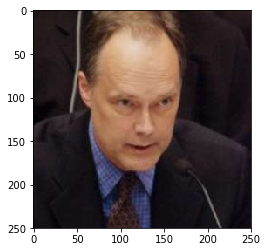

You look like Flat-coated_retriever or Briard or Dachshund


In [46]:
x = human_files_short[30]
print(x)
provide_output(x)

# Step 7: Use Fast.AI to create a model and provide predictions

In [0]:
from fastai import *
from fastai.vision import *

In [48]:
image_dir = Path(os.path.join(basedir,'images'));
train_dir = Path(train_dir)
valid_dir = Path(valid_dir)
test_dir = Path(test_dir)

image_dir, train_dir, valid_dir, test_dir

(PosixPath('/content/cloned-repository/images'),
 PosixPath('/content/cloned-repository/images/train'),
 PosixPath('/content/cloned-repository/images/valid'),
 PosixPath('/content/cloned-repository/images/test'))

In [0]:
data = (ImageList.from_folder(image_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(get_transforms(do_flip=False), size=224)
        .databunch()
        .normalize(imagenet_stats))

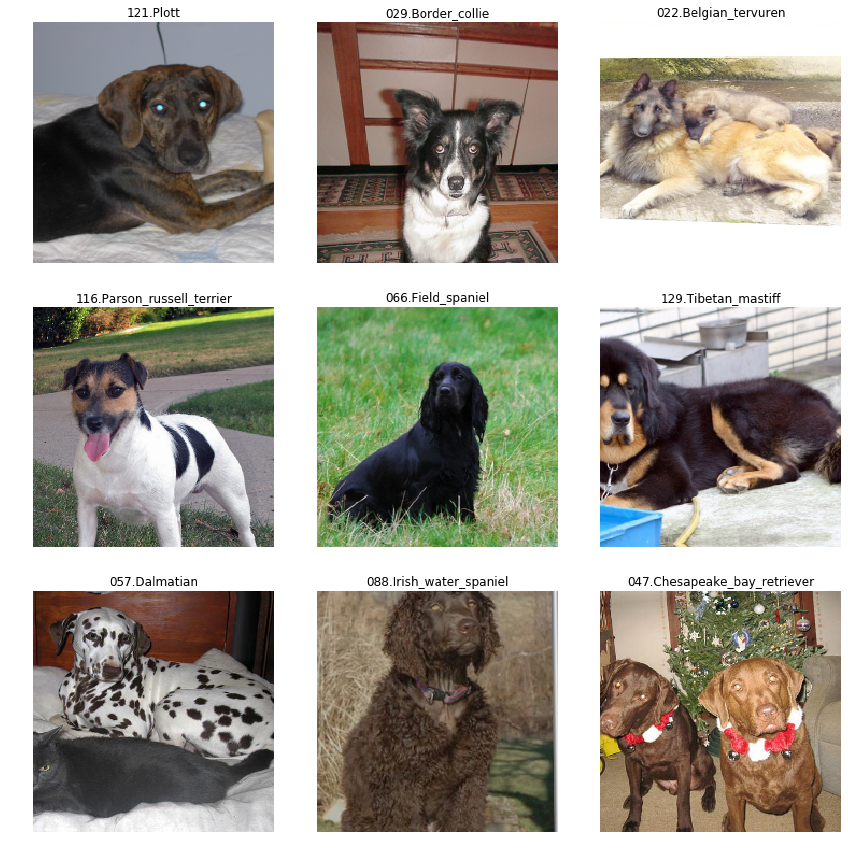

In [50]:
data.show_batch(rows=3)

In [51]:
print(data.classes)
len(data.classes),data.c

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

(133, 133)

In [0]:
learn_resnet34 = cnn_learner(data, models.resnet50, metrics=error_rate)



In [55]:
learn_resnet34.fit_one_cycle(2)
learn_resnet34.save('stage_1_resnet34')
learn_resnet34.lr_find()
learn_resnet34.recorder.plot()




epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

In [0]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet34.plot_top_losses(9, figsize=(20,20))
interp_resnet34.most_confused(min_val=2)

In [0]:
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(4, max_lr = slice(1e-6,1e-4)

In [89]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98861819.28it/s]


In [90]:
learn_resnet50.fit_one_cycle(4)
learn_resnet50.save('stage_1_resnet50')
learn_resnet50.lr_find()
learn_resnet50.recorder.plot()

interp_resnet50 = ClassificationInterpretation.from_learner(learn_resnet50)
interp_resnet50.plot_top_losses(9, figsize=(20,20))
interp_resnet50.most_confused(min_val=2)


epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

In [0]:
learn_resnet50.unfreeze()
learn_resnet50.fit_one_cycle(4, max_lr = slice(1e-6,1e-4)


